In [10]:
import gym
from gym import spaces
from rljax.algorithm import DQN
from rljax.trainer import Trainer
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from itertools import permutations
from tqdm.auto import tqdm

from environment import Env

In [4]:
data = pd.read_csv("SH_SDS_data_4.csv", index_col=0)
data.current_state = [('000'+str(cs))[-3:] for cs in data.current_state]
prob = pd.read_csv("SH_SDS_transition_matrix.csv", index_col=0)
prob.index = [('000'+str(idx))[-3:] for idx in prob.index]

In [5]:
def base_reward(action, last_state, current_state):
    return 100 if action > 100 else action

In [6]:
NUM_AGENT_STEPS = 5000
SEED = 0

env = Env(data, prob, base_reward, [1000, -500], 1000)
env_test = Env(data, prob, base_reward, [1000, -500], 1000)

algo = DQN(
    num_agent_steps=NUM_AGENT_STEPS,
    state_space=env.state_space,
    action_space=env.action_space,
    seed=SEED,
    batch_size=256,
    start_steps=1000,
    update_interval=1,
    update_interval_target=400,
    eps_decay_steps=0,
    loss_type="l2",
    lr=1e-3,
)

trainer = Trainer(
    env=env,
    env_test=env_test,
    algo=algo,
    log_dir="",
    num_agent_steps=NUM_AGENT_STEPS,
    eval_interval=1000,
    seed=SEED,
)
trainer.train()

Num steps: 1000     Return: 163.2   Time: 0:00:21
Num steps: 2000     Return: 145.3   Time: 0:00:48
Num steps: 3000     Return: 371.9   Time: 0:01:15
Num steps: 4000     Return: 230.8   Time: 0:01:38
Num steps: 5000     Return: 292.1   Time: 0:02:01


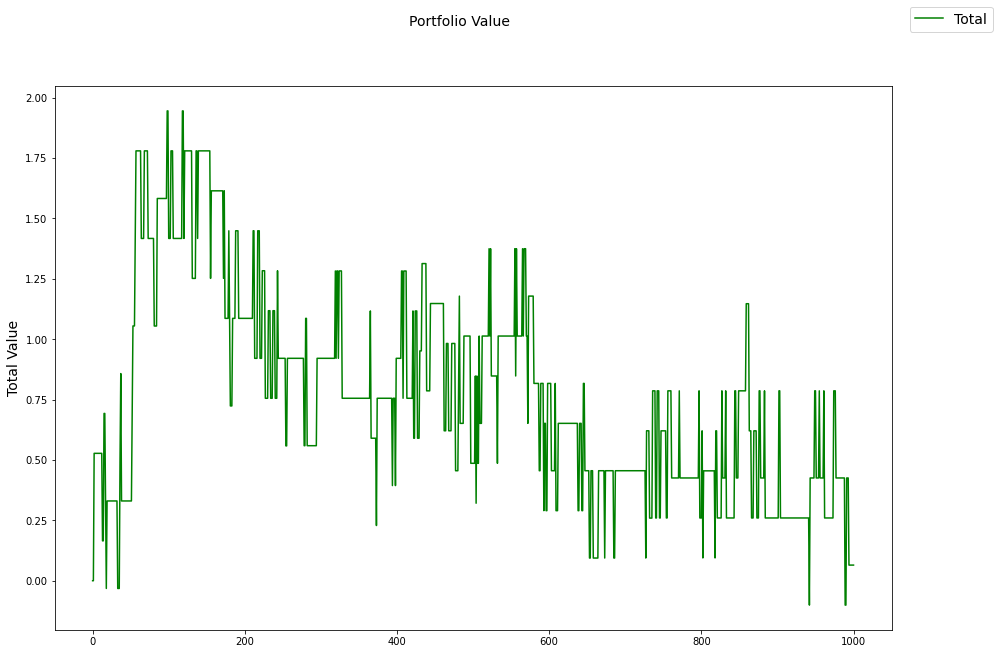

In [7]:
env.plot()

In [8]:
def sniper(state_1, state_2, env, start_state):
    state = start_state
    done = False
    all_rewards = list()
    while not done:
        if state[0] == state_1:
            state, reward, done, _ = env.step(0)
        elif state[0] == state_2:
            state, reward, done, _ = env.step(1)
        else:
            state, reward, done, _ = env.step(2)
        all_rewards.append(reward)
    return all_rewards

In [ ]:
env = Env(data, prob, base_reward, [1000, -500], 1000)
start = env.reset()
mappings = env.mapping
strategy_rewards = dict()
pairs = list(permutations(mappings.keys(), 2))
bad_pairs = list()
for s1, s2 in tqdm(pairs):
    temp_list = list()
    for _ in tqdm(range(10), desc=f'({s1}, {s2})', leave=False, position=1):
        start = env.reset()
        try:
            temp_list.append(sniper(mappings[s1], mappings[s2], env, start)[-1]) 
        except KeyError:
            bad_pairs.append((s1, s2))
    strategy_rewards[(s1, s2)] = temp_list

In [ ]:
len(bad_pairs)

In [ ]:
{k: v for k, v in sorted(strategy_rewards.items(), key=lambda item: -np.mean(item[1]))}

In [ ]:
{k: v for k, v in sorted(strategy_rewards.items(), key=lambda item: np.mean(item[1]))}